# 04_Evaluación y comunicación — Métricas, matrices y curvas de los tres modelos entrenados y comunicación de resultados

# Importación de librerías

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import average_precision_score, brier_score_loss
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score
from sklearn.metrics import (
    recall_score,
    precision_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    auc
)
import joblib

# Lectura del dataset

In [47]:
df = pd.read_csv('../data/diabetes_dataset.csv')
df.head()

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.5,Type 2,1


# Depuración de variables y definición de X y Y

In [48]:
cols_to_drop = ['diabetes_stage', 'cholesterol_total', 'glucose_postprandial']
df = df.drop(columns=cols_to_drop, errors='ignore')

X = df.drop(columns=['diagnosed_diabetes'])
y = df['diagnosed_diabetes']

print("Shape de X:", X.shape)
print("Distribución de y:")
print(y.value_counts(normalize=True))

Shape de X: (100000, 27)
Distribución de y:
diagnosed_diabetes
1    0.59998
0    0.40002
Name: proportion, dtype: float64


# División en train y test

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("\nProporción en train:")
print(y_train.value_counts(normalize=True))
print("\nProporción en test:")
print(y_test.value_counts(normalize=True))

Train: (80000, 27) Test: (20000, 27)

Proporción en train:
diagnosed_diabetes
1    0.599975
0    0.400025
Name: proportion, dtype: float64

Proporción en test:
diagnosed_diabetes
1    0.6
0    0.4
Name: proportion, dtype: float64


# Cargue de los modelos (regresión logística, árbol y random forest)

In [50]:
modelo_logreg = joblib.load("../models/modelo_logreg.joblib")
modelo_tree   = joblib.load("../models/modelo_tree.joblib")
modelo_rf     = joblib.load("../models/modelo_rf.joblib")

# Creación de diccionario

In [52]:
modelos = {
    "Regresión logística": modelo_logreg,
    "Árbol": modelo_tree,
    "Random forest": modelo_rf
}

# Evaluación de cada modelo

## Cálculo de métricas básicas

In [53]:
def metricas_basicas(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]

    recall_pos = recall_score(y_test, y_pred)
    bal_acc    = balanced_accuracy_score(y_test, y_pred)
    roc_auc    = roc_auc_score(y_test, y_proba)

    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(rec, prec)

    print("\MÉTRICAS BÁSICAS")
    print("Recall:", recall_pos)
    print("Balanced Accuracy:", bal_acc)
    print("ROC-AUC:", roc_auc)
    print("PR-AUC:", pr_auc)

## Informe de métricas

In [ ]:
def reporte_clasificacion(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    print("\n REPORTE DE CLASIFICACIÓN")
    print(classification_report(y_test, y_pred, digits=4))

## Matrices de confusión

In [55]:
def matriz_confusion(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4,3))
    plt.imshow(cm, cmap='Blues')
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.colorbar()

    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center')

    plt.show()

## Curvas ROC

In [56]:
def curva_roc(modelo, X_test, y_test):
    y_proba = modelo.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1],[0,1], '--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC")
    plt.legend()
    plt.grid()
    plt.show()

## Curvas Precision–Recall

In [57]:
def curva_pr(modelo, X_test, y_test):
    y_proba = modelo.predict_proba(X_test)[:, 1]
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(rec, prec)

    plt.figure(figsize=(5,4))
    plt.plot(rec, prec, label=f"PR-AUC = {pr_auc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Curva Precision–Recall")
    plt.legend()
    plt.grid()
    plt.show()

## Curvas de aprendizaje

In [58]:
def curva_aprendizaje(modelo, X_train, y_train, scoring="recall"):
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator=modelo,
        X=X_train,
        y=y_train,
        cv=5,
        scoring=scoring,
        n_jobs=-1,
        shuffle=True,
        random_state=42,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_mean = train_scores.mean(axis=1)
    valid_mean = valid_scores.mean(axis=1)

    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_mean, 'o-', label="Train")
    plt.plot(train_sizes, valid_mean, 'o-', label="Validation")
    plt.xlabel("Tamaño del conjunto")
    plt.ylabel(scoring.capitalize())
    plt.title("Curva de Aprendizaje")
    plt.legend()
    plt.grid()
    plt.show()

## Evaluación global de los modelos

In [59]:
def evaluar(nombre, modelo, X_train, y_train, X_test, y_test):
    print("\n==============================")
    print(f"     MODELO: {nombre}")
    print("==============================\n")

    metricas_basicas(modelo, X_test, y_test)
    reporte_clasificacion(modelo, X_test, y_test)
    matriz_confusion(modelo, X_test, y_test)
    curva_roc(modelo, X_test, y_test)
    curva_pr(modelo, X_test, y_test)
    curva_aprendizaje(modelo, X_train, y_train)


     MODELO: Regresión logística

\MÉTRICAS BÁSICAS
Recall: 0.8775
Balanced Accuracy: 0.8899999999999999
ROC-AUC: 0.9339465729166667
PR-AUC: 0.966961949533634

📄 REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

           0     0.8308    0.9025    0.8652      8000
           1     0.9310    0.8775    0.9035     12000

    accuracy                         0.8875     20000
   macro avg     0.8809    0.8900    0.8843     20000
weighted avg     0.8910    0.8875    0.8882     20000



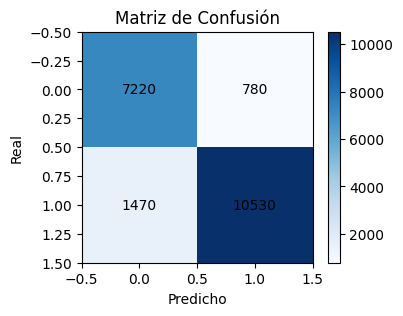

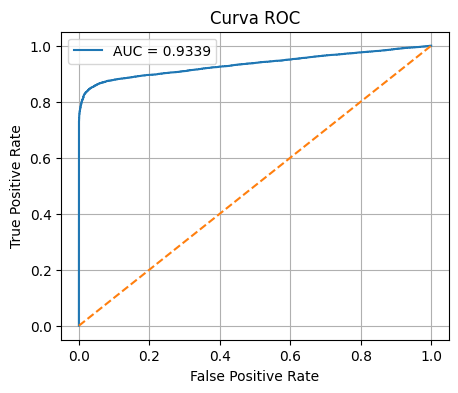

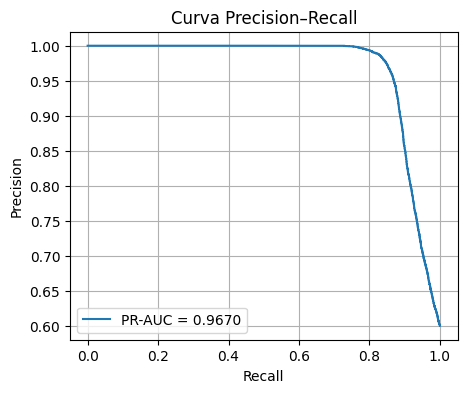

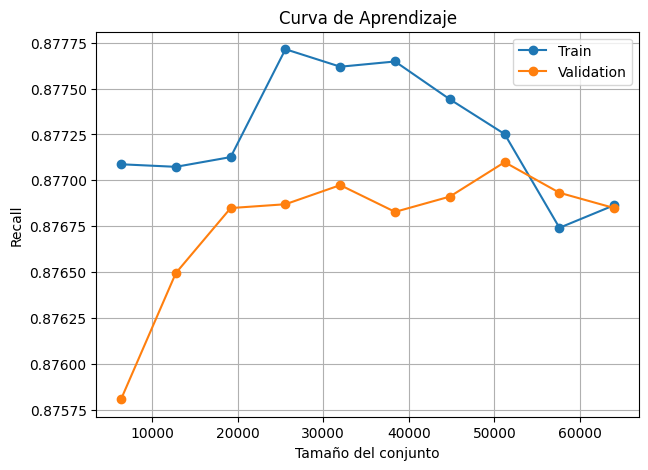


     MODELO: Árbol

\MÉTRICAS BÁSICAS
Recall: 0.8945
Balanced Accuracy: 0.852875
ROC-AUC: 0.8528749999999999
PR-AUC: 0.9172371447239464

📄 REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

           0     0.8368    0.8113    0.8238      8000
           1     0.8767    0.8945    0.8855     12000

    accuracy                         0.8612     20000
   macro avg     0.8567    0.8529    0.8547     20000
weighted avg     0.8607    0.8612    0.8608     20000



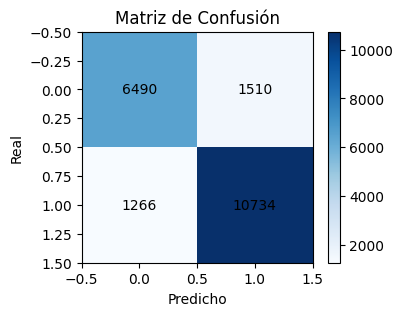

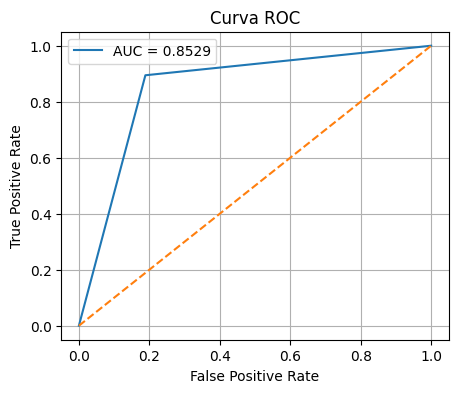

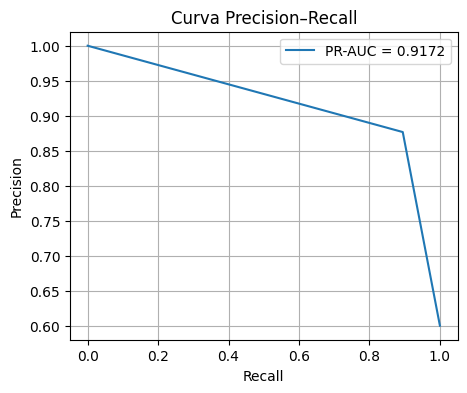

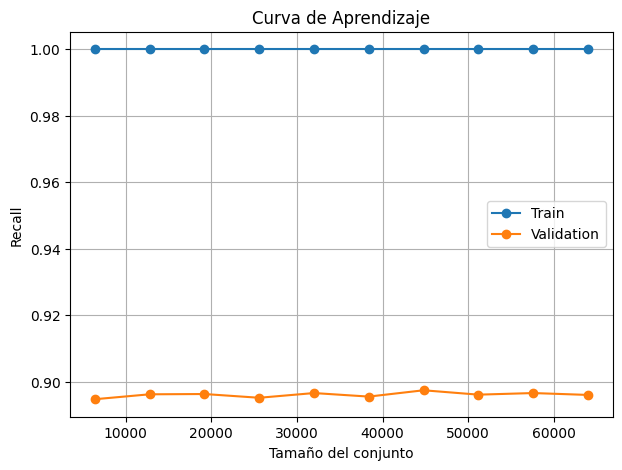


     MODELO: Random forest

\MÉTRICAS BÁSICAS
Recall: 0.8675
Balanced Accuracy: 0.9321250000000001
ROC-AUC: 0.9419305052083333
PR-AUC: 0.9711411219484485

📄 REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

           0     0.8338    0.9968    0.9080      8000
           1     0.9975    0.8675    0.9280     12000

    accuracy                         0.9192     20000
   macro avg     0.9156    0.9321    0.9180     20000
weighted avg     0.9320    0.9192    0.9200     20000



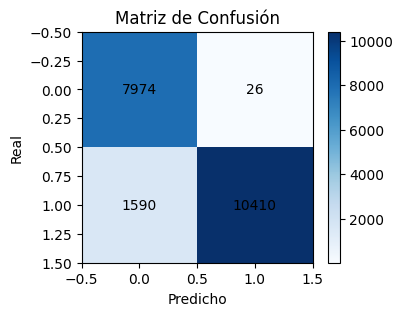

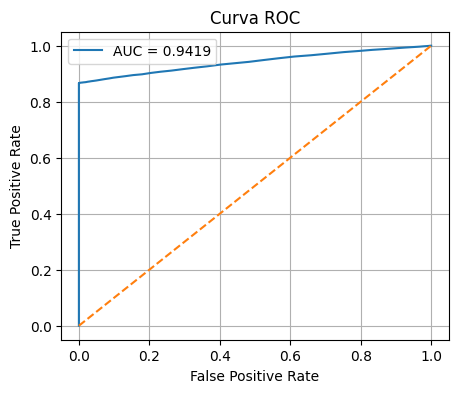

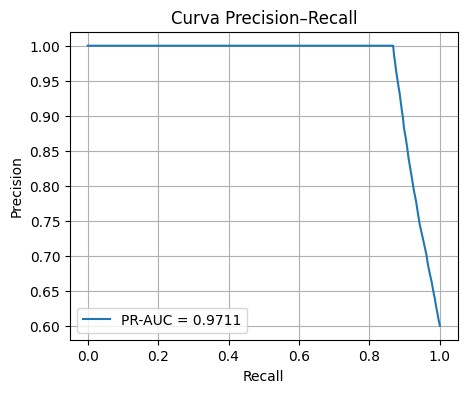

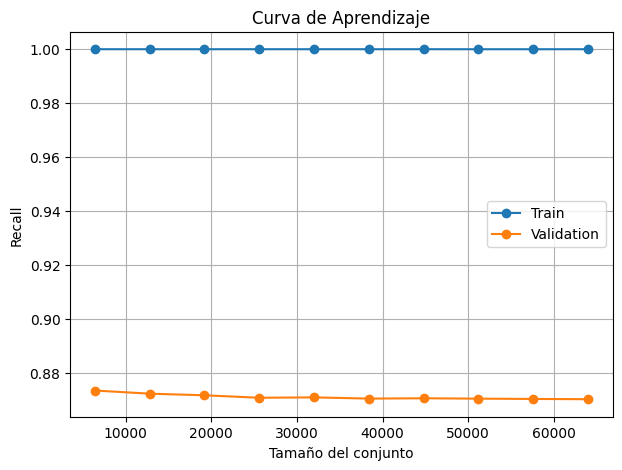

In [60]:
evaluar("Regresión logística", modelo_logreg, X_train, y_train, X_test, y_test)
evaluar("Árbol", modelo_tree, X_train, y_train, X_test, y_test)
evaluar("Random forest", modelo_rf, X_train, y_train, X_test, y_test)

# Interpretación del modelo de regresión logística

El modelo de regresión logística presenta un desempeño interesante en la detección de diabetes, con una alta sensibilidad (recall del 87.75 %), adecuada discriminación entre clases (ROC-AUC de 0.934) y muy buen rendimiento sobre la clase positiva (PR-AUC de 0.967), además de una balanced accuracy de 0.89 que confirma su consistencia. La matriz de confusión evidencia un buen número de aciertos, aunque destaca la presencia de falsos negativos y algunos falsos positivos. Las gráficas de ROC, Precision–Recall y la curva de aprendizaje muestran un comportamiento estable, sin sobreajuste y con capacidad discriminativa robusta.

# Coeficientes del modelo de regresión logística

In [36]:
coef = modelo_logreg.named_steps['clf'].coef_[0]
features = modelo_logreg.named_steps['preproc'].get_feature_names_out()
coef_df = pd.DataFrame({'feature': features, 'coef': coef})
coef_df = coef_df.sort_values(by='coef', ascending=False)
coef_df

,feature,coef
16,num_scaled__hba1c,3.085619
14,num_scaled__glucose_fasting,0.235255
17,num_scaled__diabetes_risk_score,0.145072
23,cat__gender_Other,0.130251
18,num_binary__family_history_diabetes,0.115358
33,cat__income_level_High,0.109503
41,cat__employment_status_Unemployed,0.088468
31,cat__education_level_No formal,0.083826
43,cat__smoking_status_Former,0.082217
44,cat__smoking_status_Never,0.079201


**Nota:** los coeficientes de la regresión logística muestran que los factores metabólicos son los que más pesan en el diagnóstico de diabetes: la hemoglobina glicosilada (HbA1c) es el predictor más fuerte, seguida de la glucosa en ayunas y el puntaje de riesgo. También influyen, aunque en menor medida, los antecedentes familiares, algunos niveles de ingreso, educación, ocupación y ciertas características demográficas, que más que ser causas directas reflejan estilos de vida o condiciones socioeconómicas asociadas al riesgo. Por el lado protector, destacan la actividad física, el HDL, el buen sueño y otros hábitos saludables, cuyos coeficientes negativos reducen la probabilidad de diabetes.

# Interpretación del modelo de árbol

El árbol de decisión muestra mayor flexibilidad y un recall un poco superior al de la regresión logística (89.45 %), detectando más casos positivos, pero esa ganancia viene acompañada de una caída en métricas globales como la balanced accuracy y el ROC-AUC (ambas de 0.853), lo que evidencia menor capacidad discriminativa. Aunque reduce los falsos negativos, aumenta los falsos positivos y presenta un claro sobreajuste: obtiene casi perfección en entrenamiento, pero su desempeño en validación no mejora con más datos. Las curvas ROC y Precision–Recall confirman esta menor precisión y estabilidad frente al anterior modelo. 

# Importancia de las variables del modelo de árbol

In [37]:
importances = modelo_tree.named_steps['clf'].feature_importances_
features = modelo_tree.named_steps['preproc'].get_feature_names_out()
imp_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)
imp_df

,feature,importance
16,num_scaled__hba1c,0.755495
14,num_scaled__glucose_fasting,0.035980
17,num_scaled__diabetes_risk_score,0.014781
15,num_scaled__insulin_level,0.014603
2,num_scaled__physical_activity_minutes_per_week,0.013266
13,num_scaled__triglycerides,0.012652
5,num_scaled__screen_time_hours_per_day,0.012477
3,num_scaled__diet_score,0.012226
8,num_scaled__systolic_bp,0.011985
6,num_scaled__bmi,0.011018


**Nota:** los resultados de importancia de variables del árbol muestran que la variable HbA1c domina por completo el modelo, aportando más del 75 % del peso total  para clasificar a una persona como diabética o no. Aunque otras variables metabólicas como la glucosa en ayunas, el puntaje de riesgo, la insulina, los triglicéridos o la presión arterial contribuyen, su peso es muy pequeño. El resto de variables aportan muy poca información adicional.

# Interpretación del modelo de random forest

Aunque el random forest alcanza métricas sobresalientes (un ROC-AUC de 0.942, un PR-AUC de 0.971, una balanced accuracy de 0.93 y un recall de 86.75 %), la curva de aprendizaje muestra un sobreajuste bastante grande: el rendimiento en entrenamiento es prácticamente perfecto (cercano a 1), mientras que el de validación se queda alrededor de 0.87 y no converge. Esto indica que, pese a su excelente capacidad discriminativa y su sólido equilibrio entre clases, el modelo está aprendiendo patrones demasiado específicos del conjunto de entrenamiento, lo que limita su verdadera capacidad de generalización.

# Importancia de las variables del modelo de random forest

In [38]:
importances = modelo_rf.named_steps['clf'].feature_importances_
features = modelo_rf.named_steps['preproc'].get_feature_names_out()
rf_imp_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)
rf_imp_df

,feature,importance
16,num_scaled__hba1c,0.551623
14,num_scaled__glucose_fasting,0.130608
17,num_scaled__diabetes_risk_score,0.031316
2,num_scaled__physical_activity_minutes_per_week,0.018133
0,num_scaled__age,0.017625
6,num_scaled__bmi,0.016944
13,num_scaled__triglycerides,0.016332
15,num_scaled__insulin_level,0.016157
12,num_scaled__ldl_cholesterol,0.015469
3,num_scaled__diet_score,0.015465


**Nota:** los resultados de importancia de variables del random forest muestran que HbA1c es nuevamente el predictor más influyente, aportando más del 55 % de la importancia total, seguida de otras variables metabólicas como la glucosa en ayunas, el puntaje de riesgo, la actividad física, la edad, el IMC, los triglicéridos y la insulina. A diferencia del árbol individual, el random forest reparte el peso de manera más equilibrada entre varios factores metabólicos y fisiológicos. En contraste, las variables demográficas, socioeconómicas y de estilo de vida tienen un peso mucho menor.

# ¿Cual es el mejor modelo hasta ahora?

Dado que la regresión logística es el único modelo que no presenta sobreajuste, mantiene métricas sólidas, y además es simple, estable y altamente interpretable, se selecciona como el mejor entre los tres modelos entrenados y evaluados. Por esta razón, será el modelo elegido para continuar la experimentación, ajustando el umbral de decisión hasta identificar el punto óptimo de desempeño.

# Búsqueda del umbral óptimo para el modelo de regresión logística priorizando recall sin sacrificar mucho la precisión

In [42]:
y_proba = modelo_logreg.predict_proba(X_test)[:, 1]

umbrales = np.arange(0.05, 0.9, 0.05)

mejor_recall = 0
mejor_umbral = 0.5
mejor_precision = 0

precision_minima = 0.70  

for u in umbrales:
    y_pred_adj = (y_proba >= u).astype(int)
    
    rec = recall_score(y_test, y_pred_adj)
    prec = precision_score(y_test, y_pred_adj, zero_division=0)

    if prec >= precision_minima and rec > mejor_recall:
        mejor_recall = rec
        mejor_umbral = u
        mejor_precision = prec

print("Mejor umbral priorizando Recall (con precisión mínima):", mejor_umbral)
print("Recall logrado:", mejor_recall)
print("Precisión correspondiente:", mejor_precision)

y_pred_final = (y_proba >= mejor_umbral).astype(int)

Mejor umbral priorizando Recall (con precisión mínima): 0.1
Recall logrado: 0.94625
Precisión correspondiente: 0.714555408721918


**Nota:** el umbral óptimo para priorizar la sensibilidad sin sacrificar excesivamente la precisión fue 0.10. Con este umbral, el modelo logra un recall de 94.6 %, identificando a la gran mayoría de los casos positivos, lo cual es deseable en un contexto clínico de tamizaje. Aunque la precisión disminuye hasta 71.4 %, se mantiene por encima del mínimo requerido (0.70), indicando que el incremento de falsos positivos es manejable y clínicamente aceptable para un escenario de detección temprana.

# Entrenar los calibradores (platt e isotónica) para el modelo de regresión logística

In [43]:
from sklearn.calibration import CalibratedClassifierCV
modelo_base = modelo_logreg  

cal_platt = CalibratedClassifierCV(estimator=modelo_base,
                                   method='sigmoid',
                                   cv=5)
cal_platt.fit(X_train, y_train)

cal_iso = CalibratedClassifierCV(estimator=modelo_base,
                                 method='isotonic',
                                 cv=5)
cal_iso.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'
,transformers,"[('num_scaled', ...), ('num_binary', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [44]:
y_proba_base = modelo_base.predict_proba(X_test)[:, 1]

y_proba_platt = cal_platt.predict_proba(X_test)[:, 1]
y_proba_iso   = cal_iso.predict_proba(X_test)[:, 1]

In [45]:
from sklearn.metrics import average_precision_score, brier_score_loss

def evaluar_probs(nombre, y_true, y_proba):
    roc = roc_auc_score(y_true, y_proba)
    pr  = average_precision_score(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    print(f"\n=== {nombre} ===")
    print("ROC-AUC:   ", roc)
    print("PR-AUC:    ", pr)
    print("Brier score (↓ mejor):", brier)

evaluar_probs("Modelo base (sin calibrar)", y_test, y_proba_base)
evaluar_probs("Calibrado Platt (sigmoid)", y_test, y_proba_platt)
evaluar_probs("Calibrado isotónico",       y_test, y_proba_iso)


=== Modelo base (sin calibrar) ===
ROC-AUC:    0.9339465729166667
PR-AUC:     0.966963015887198
Brier score (↓ mejor): 0.09715868669399796

=== Calibrado Platt (sigmoid) ===
ROC-AUC:    0.9339482291666666
PR-AUC:     0.9669641428226629
Brier score (↓ mejor): 0.10118245793784383

=== Calibrado isotónico ===
ROC-AUC:    0.9339395833333334
PR-AUC:     0.9662901505345869
Brier score (↓ mejor): 0.081006123651563


**Nota:** la regresión logística sin calibrar ya presenta una calibración adecuada, pero la calibración isotónica reduce un poco el Brier score (de 0.097 a 0.081), lo que indica una mejora en la correspondencia entre probabilidades predichas y resultados reales. Sin embargo, ni Platt ni la calibración isotónica mejoran la capacidad discriminativa del modelo (ROC-AUC y PR-AUC prácticamente se mantienen iguales), lo cual confirma que la regresión logística ya estaba correctamente ajustada en ese aspecto.

# Conclusión final (el mejor modelo)

**Nota:** aunque se exploraron variantes calibradas del modelo de regresión logística mediante Platt (sigmoid) y regresión isotónica, se decidió almacenar y utilizar como modelo principal la regresión logística sin calibrar. En primer lugar, este modelo es el único de los tres evaluados que no presentó sobreajuste, mostrando curvas de aprendizaje estables y un desempeño muy similar entre entrenamiento y validación, lo que indica una buena capacidad de generalización. En segundo lugar, sus métricas de rendimiento son decentes (ROC-AUC = 0.93, PR-AUC = 0.97, balanced accuracy = 0.89 y recall para casos positivos = 0.89). En tercer lugar, la regresión logística ofrece una alta interpretabilidad, permitiendo cuantificar de forma directa el efecto de cada predictor sobre la probabilidad estimada de que una persona pertenezca a la clase diabética, algo especialmente valioso en contextos clínicos, donde es importante explicar por qué el modelo clasifica a una persona como positiva o negativa según sus características.